In [1]:
import masuite
from masuite.agents.pytorch.policy_gradient import PGAgent
from masuite.algos.pytorch.simplepg import SimplePG
from masuite.algos.pytorch.stackpg import StackPG
from masuite.algos import experiment

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import random

In [13]:
def train_agents(AlgCls):
    env = masuite.load_from_id("soccer/0")
    #env.seed()
    agents = [PGAgent(
        env_dim=env.env_dim, n_acts=env.n_acts, hidden_sizes=[256, 128], seed=None) 
        for _ in range(2)
    ]
    alg = AlgCls(agents, env.shared_state, env.n_players, 5000)
    logger = masuite.init_logging(
        filename=f"{AlgCls.__name__}-experiment",
        n_players=2,
        mode="csv",
        save_path="tmp/masuite",
        overwrite=True,
        log_freq=10,
        log_checkpoints=False,
        checkpoint_freq=10,
        params=None
    )
    experiment.run(alg, env, logger, 50, False)
    return agents

In [14]:
simplepg_agents = train_agents(SimplePG)
stackpg_agents = train_agents(StackPG)

Loaded masuite_id: soccer/0.
[Linear(in_features=84, out_features=256, bias=True), Tanh(), Linear(in_features=256, out_features=128, bias=True), Tanh(), Linear(in_features=128, out_features=5, bias=True), Identity()]
[Linear(in_features=84, out_features=256, bias=True), Tanh(), Linear(in_features=256, out_features=128, bias=True), Tanh(), Linear(in_features=128, out_features=5, bias=True), Identity()]
Logging to file: tmp/masuite/SimplePG-experiment.csv


In [ ]:
from masuite.experiments.smallsoccer.analysis import simple_score
stackpg_path = "/home/zanedma/code/research/masuite/notebooks/tmp/masuite/StackPG-experiment.csv"
simplepg_path = "/home/zanedma/code/research/masuite/notebooks/tmp/masuite/SimplePG-experiment.csv"
scores = [simple_score(stackpg_path), simple_score(simplepg_path)]
print(scores)

[1.0, 0.46]


In [6]:
def plot_rets(title, df):
    plt.title(title)
    plt.plot(df["agent0_avg_rets"], label="player 1")
    plt.plot(df["agent1_avg_rets"], label="player 2")
    plt.legend()
    plt.show()

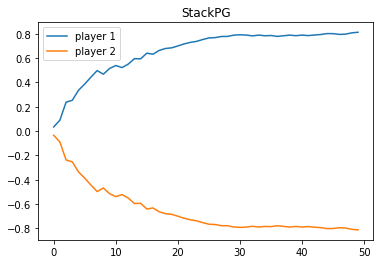

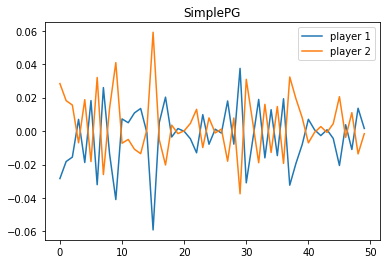

In [7]:
stack_df = pd.read_csv(stackpg_path)
plot_rets("StackPG", stack_df)
simple_df = pd.read_csv(simplepg_path)
plot_rets("SimplePG", simple_df)

In [8]:
def run_loop(act_fns, env_id):
    scores = []
    local_env = masuite.load_from_id(env_id)
    local_env.seed()
    for epoch in range(50):
        obs = local_env.reset()
        score = [0, 0]
        for _ in range(5000):
            acts = [act_fn(obs) for act_fn in act_fns]
            obs, rews, done, _ = local_env.step(acts)
            if done:
                if rews[0] > 0:
                    score[0] += 1
                elif rews[1] > 0:
                    score[1] += 1
        #print(f"epoch {epoch}: {score}")        
        scores.append(score[0]/(score[0]+score[1]))
        #print(scores[-1])
    return scores

In [10]:
env_id = "soccer/0"
random_select_action = lambda _: random.choice(range(5))

leader = stackpg_agents[0]
leader_vs_random = run_loop([leader.select_action, random_select_action], env_id)

follower = stackpg_agents[1]
random_vs_follower = run_loop([random_select_action, follower.select_action], env_id)

simple1_vs_random = run_loop([simplepg_agents[0].select_action, random_select_action], env_id)
random_vs_simple2 = run_loop([random_select_action, simplepg_agents[1].select_action], env_id)

Loaded masuite_id: soccer/0.
Loaded masuite_id: soccer/0.
Loaded masuite_id: soccer/0.
Loaded masuite_id: soccer/0.


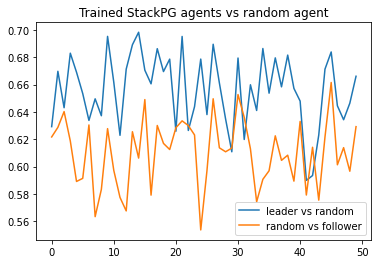

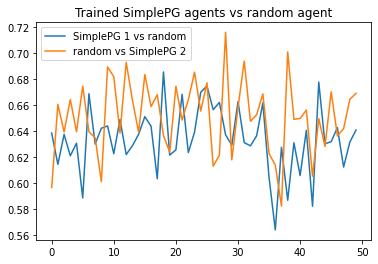

In [11]:
plt.plot(leader_vs_random, label="leader vs random")
plt.plot(random_vs_follower, label="random vs follower")
plt.legend()
plt.title("Trained StackPG agents vs random agent")
plt.show()

plt.plot(simple1_vs_random, label="SimplePG 1 vs random")
plt.plot([1-val for val in random_vs_simple2], label="random vs SimplePG 2")
plt.legend()
plt.title("Trained SimplePG agents vs random agent")
plt.show()

In [12]:
def run_tournament(agents, masuite_id):
    scores = []
    local_env = masuite.load_from_id(masuite_id)
    local_env.seed()
    for epoch in range(50):
        obs = local_env.reset()
        score = [0, 0]
        for _ in range(5000):
            acts = [agent.select_action(obs) for agent in agents]
            obs, rews, done, _ = local_env.step(acts)
            if done:
                if rews[0] > 0:
                    score[0] += 1
                elif rews[1] > 0:
                    score[1] += 1
        print(f"epoch {epoch}: {score}")        
        scores.append(score[0]/(score[0]+score[1]))
        print(scores[-1])
    return scores

In [15]:
leader_leader = run_tournament([leader, leader], env_id)
follower_follower = run_tournament([follower, follower], env_id)
spg1_spg1 = run_tournament([simplepg_agents[0], simplepg_agents[0]], env_id)
spg2_spg2 = run_tournament([simplepg_agents[1], simplepg_agents[1]], env_id)

Loaded masuite_id: smallsoccer/0.
epoch 0: [3529, 2]
0.9994335882186349
epoch 1: [3536, 0]
1.0
epoch 2: [3535, 0]
1.0
epoch 3: [3529, 2]
0.9994335882186349
epoch 4: [3522, 5]
0.9985823646158208
epoch 5: [3533, 1]
0.9997170345217884
epoch 6: [3532, 1]
0.9997169544296631
epoch 7: [3527, 1]
0.9997165532879818
epoch 8: [3528, 3]
0.9991503823279524
epoch 9: [3519, 6]
0.9982978723404256
epoch 10: [3536, 0]
1.0
epoch 11: [3535, 0]
1.0
epoch 12: [3533, 1]
0.9997170345217884
epoch 13: [3529, 2]
0.9994335882186349
epoch 14: [3536, 0]
1.0
epoch 15: [3530, 2]
0.9994337485843715
epoch 16: [3536, 0]
1.0
epoch 17: [3533, 0]
1.0
epoch 18: [3531, 1]
0.9997168742921857
epoch 19: [3532, 1]
0.9997169544296631
epoch 20: [3535, 0]
1.0
epoch 21: [3530, 2]
0.9994337485843715
epoch 22: [3535, 0]
1.0
epoch 23: [3529, 2]
0.9994335882186349
epoch 24: [3528, 3]
0.9991503823279524
epoch 25: [3536, 0]
1.0
epoch 26: [3527, 2]
0.9994332672145083
epoch 27: [3532, 1]
0.9997169544296631
epoch 28: [3529, 3]
0.999150622876

KeyboardInterrupt: 

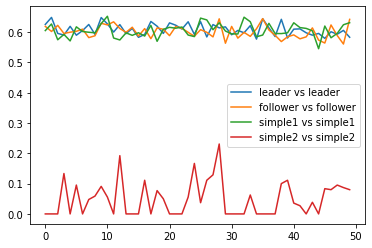

In [ ]:

plt.plot(leader_leader, label="leader vs leader")
plt.plot(follower_follower, label="follower vs follower")
plt.plot(spg1_spg1, label="simple1 vs simple1")
plt.plot(spg2_spg2, label="simple2 vs simple2")
plt.legend()

In [ ]:
# leader vs random
# random vs follower
# simple1 vs random
# random vs simple2
# leader vs simple2
# simple1 vs follower


# leader vs simple2 challenger - leader is fixed follower learns from it
# leader challenger vs follower


# simple challenger vs random
# leader challenger vs random?